## hitmap을 이용한 corr 시각화

In [34]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
users = pd.read_csv('./data/' + 'users.csv')
books = pd.read_csv('./data/' + 'books.csv')
train = pd.read_csv('./data/' + 'train_ratings.csv')
test = pd.read_csv('./data/' + 'test_ratings.csv')
sub = pd.read_csv('./data/' + 'sample_submission.csv')

In [35]:
def make_category_high(books:pd.DataFrame) -> pd.DataFrame:
    books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
    books['category'] = books['category'].str.lower()
    categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
    'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
    'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
    'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

    books['category_high'] = books['category'].copy()
    for category in categories:
        books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category
        
    category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
    category_high_df.columns = ['category','count']
    others_list = category_high_df[category_high_df['count']<5]['category'].values
    books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'
    return books
books = make_category_high(books)

In [36]:
test_df = train.merge(users, how="left", on='user_id')
test_df = test_df.merge(books, how="left", on='isbn')

In [37]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [38]:
test_df['location_city'] = test_df['location'].apply(lambda x: x.split(',')[0])
test_df['location_state'] = test_df['location'].apply(lambda x: x.split(',')[1])
test_df['location_country'] = test_df['location'].apply(lambda x: x.split(',')[2])
test_df = test_df.drop(['location'], axis=1)

In [39]:
test_df['book_author'] = test_df['book_author'].str.replace('.','', regex=True)
test_df['book_author'] = test_df['book_author'].str.replace('_',' ', regex=True)
test_df['book_author'] = test_df['book_author'].str.lower()
test_df['book_author'] = test_df['book_author'].apply(lambda x:' '.join(sorted(x.split())))

In [40]:
loc_city2idx = {v:k for k,v in enumerate(test_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(test_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(test_df['location_country'].unique())}
category2idx = {v:k for k,v in enumerate(test_df['category'].unique())}
categoryhigh2idx = {v:k for k,v in enumerate(test_df['category_high'].unique())}
publisher2idx = {v:k for k,v in enumerate(test_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(test_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(test_df['book_author'].unique())}

In [41]:
test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)
test_df['category'] = test_df['category'].map(category2idx)
test_df['category_high'] = test_df['category_high'].map(categoryhigh2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

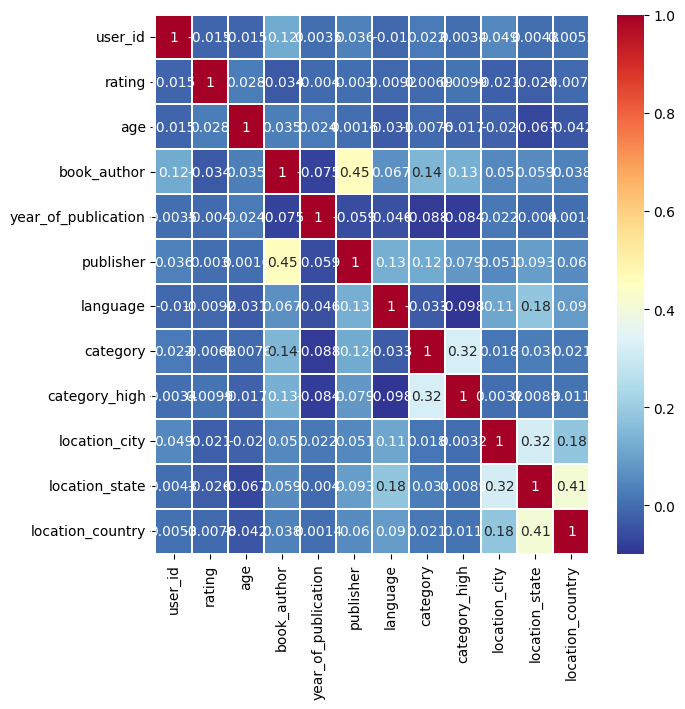

In [46]:
plt.figure(figsize = (7, 7))
sns.heatmap(test_df.corr(), linewidths=0.1, vmax=1, cmap='RdYlBu_r', linecolor='white',annot=True)
plt.show()